In [50]:
import os
import sys
import scipy.io
import scipy.misc
import imageio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from imutils import paths
import cv2
import imutils

from matplotlib.pyplot import imshow
from PIL import Image

%matplotlib inline

In [ ]:
# check this out https://medium.com/mlreview/making-ai-art-with-style-transfer-using-keras-8bb5fa44b216

# https://github.com/hnarayanan/artistic-style-transfer/blob/master/notebooks/6_Artistic_style_transfer_with_a_repurposed_VGG_Net_16.ipynb

In [38]:
class CONFIG:
    IMAGE_WIDTH = (512*2)
    IMAGE_HEIGHT = (512*2)
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    VGG_MODEL = 'pretrained-model/imagenet-vgg-verydeep-19.mat' # VGG 19-layer model
    STYLE_IMAGE = 'images/stone_style.jpg' # Style image to use.
    CONTENT_IMAGE = 'images/content300.jpg' # Content image to use.
    OUTPUT_DIR = 'output/'

In [39]:
def load_vgg_model(path):
    
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b

        return W, b

    def _relu(conv2d_layer):
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph

In [4]:
def generate_noise_image(content_image, noise_ratio = CONFIG.NOISE_RATIO):
    
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (1, 
                                    CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)).astype('float32')
    
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return input_image

In [5]:
def reshape_and_normalize_image(image):
    
    # Reshape image to mach expected input of VGG16
    image = np.reshape(image, ((1,) + image.shape))
    
    # Substract the mean to match the expected input of VGG16
    image = image - CONFIG.MEANS
    
    return image

In [6]:
def resize_images(content_path, style_path, width, height, verbose=-1):
    
    images = []
    
    content_image = imageio.imread(content_path)
    style_image = imageio.imread(style_path)
    
    images.append(content_image)
    images.append(style_image)
    
    images = np.array(images)
    
    resized_images = []
    
    for i in range(len(images)):
        
        (h, w) = images[i].shape[:2]
        inter = cv2.INTER_AREA
        dW = 0
        dH = 0
        
        if w < h:
            image = imutils.resize(images[i], width=width, inter=inter)
            dH = int((image.shape[0] - height) / 2.0)
            
        else:
            image = imutils.resize(images[i], height=height, inter=inter)
            dW = int((image.shape[1] - width) / 2.0)

        (h, w) = image.shape[:2]
        image = image[dH:h - dH, dW:w - dW]

        image = cv2.resize(image, (width, height), interpolation=inter)
        resized_images.append(image)
        
        
    return(np.array(resized_images - CONFIG.MEANS))

In [10]:
def save_image(path, image):
    
    # Un-normalize the image so that it looks good
    image = image + CONFIG.MEANS
    
    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    imageio.imwrite(path, image)

In [11]:
model = load_vgg_model("pretrained_models/imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 512, 512, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 512, 512, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 512, 512, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 256, 256, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 256, 256, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 256, 256, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 128, 128, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 128, 128, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 128, 128, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 128, 128, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 128, 128, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 64, 64, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 64, 64, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0'

In [ ]:
# Now that the model is stored, we can run and image through the network using the tf.assign function. See example below

# model["input"].assign(image)

# Now, if you want to access the activations of a particular layer, say layer 4_2 when the network is run on this image, 
# you would run a TensorFlow session on the correct tensor conv4_2, as follows:

# sess.run(model["conv4_2"])

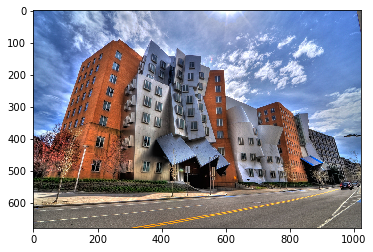

In [12]:
#let's load a content image
content_image = imageio.imread("data/style_transfer/input/stata.jpg")
imshow(content_image)

In [13]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.transpose(tf.reshape(a_C, [-1]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G, [-1]))
    
    # compute the cost with tensorflow (≈1 line)
    J_content = tf.reduce_sum((a_C_unrolled - a_G_unrolled)**2) / (4 * n_H * n_W * n_C)
    
    return J_content

In [14]:
# Example
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.765593


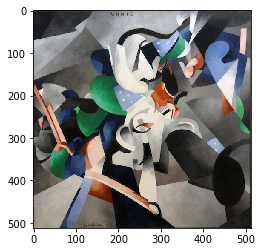

In [15]:
# Print style image
style_image = imageio.imread("data/style_transfer/input/udnie.jpg")
imshow(style_image)

In [16]:
#Gram matrix
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    GA = tf.matmul(A, tf.transpose(A)) # '*' is elementwise mul in numpy
    
    return GA

In [17]:
# Print out Gram matrix

tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval()))

GA = [[ 6.422305 -4.429122 -2.096682]
 [-4.429122 19.465837 19.563871]
 [-2.096682 19.563871 20.686462]]


In [18]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_H*n_W, n_C)
    a_S = tf.reshape(a_S, [n_H*n_W, n_C])
    a_G = tf.reshape(a_G, [n_H*n_W, n_C])

    # Computing gram_matrices for both images S and G
    GS = gram_matrix(tf.transpose(a_S)) #input of gram_matrix is A: matrix of shape (n_C, n_H*n_W)
    GG = gram_matrix(tf.transpose(a_G))

    # Computing the loss
    J_style_layer = tf.reduce_sum((GS - GG)**2) / (4 * n_C**2 * (n_W * n_H)**2)
    
    return J_style_layer

In [19]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.190278


In [20]:
# Weights for the conv layers, let's start with default vaules

STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [21]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [22]:
def total_cost(J_content, J_style, alpha = 10, beta = 70):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = alpha * J_content + beta * J_style
    
    return J

In [23]:
# Testing total cost

tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 48.441974270142445


In [40]:
# Start interactive session

tf.reset_default_graph()
sess = tf.InteractiveSession()

In [41]:
style_path = 'data/style_transfer/input/udnie.jpg'
content_path = 'data/style_transfer/input/stata.jpg'

In [42]:
processed_images = resize_images(content_path, style_path, 1024, 1024)
content_image = np.expand_dims(processed_images[0], axis=0)
style_image = np.expand_dims(processed_images[1], axis=0)

In [53]:
# Reshape and normalize content image and style image

content_image = imageio.imread("data/style_transfer/input/vandg.jpg")
content_image = reshape_and_normalize_image(content_image)

style_image = imageio.imread("data/style_transfer/input/wedding")
style_image = reshape_and_normalize_image(style_image)

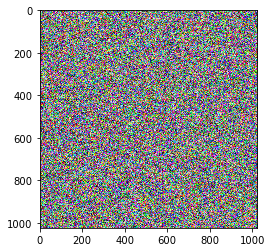

In [43]:
# Now we initialize the generated image by creating a noise image that is slightly correlated with content image

generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [44]:
# Load model
model = load_vgg_model("pretrained_models/imagenet-vgg-verydeep-19.mat")

# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [45]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [46]:
# Compute total cost: J_Content + J_Style

J = total_cost(J_content, J_style,  alpha = 15, beta = 100)

In [47]:
# define optimizer
optimizer = tf.train.AdamOptimizer(1.0)

# define train_step
train_step = optimizer.minimize(J)

In [48]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        _ = sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("data/style_transfer/output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('data/style_transfer/output/generated_image.jpg', generated_image)
    
    return generated_image

In [49]:
model_nn(sess, generated_image, num_iterations = 200)

Iteration 0 :
total cost = 7452582400.0
content cost = 7469.9595
style cost = 74524700.0
Iteration 20 :
total cost = 2043247500.0
content cost = 9085.34
style cost = 20431112.0
Iteration 40 :
total cost = 1154717600.0
content cost = 9633.286
style cost = 11545731.0
Iteration 60 :
total cost = 848685500.0
content cost = 10027.2
style cost = 8485351.0
Iteration 80 :
total cost = 678392400.0
content cost = 10352.926
style cost = 6782371.5
Iteration 100 :
total cost = 563011650.0
content cost = 10631.874
style cost = 5628521.5
Iteration 120 :
total cost = 476936500.0
content cost = 10880.932
style cost = 4767733.0
Iteration 140 :
total cost = 409232450.0
content cost = 11112.035
style cost = 4090657.5
Iteration 160 :
total cost = 354309730.0
content cost = 11320.325
style cost = 3541399.5
Iteration 180 :
total cost = 308844930.0
content cost = 11519.6045
style cost = 3086721.2


array([[[[-4.77408905e+01, -1.12335697e-01,  6.74327393e+01],
         [ 5.80284004e+01,  6.52096939e+01,  1.00920486e+02],
         [ 4.86743317e+01,  6.45172272e+01,  1.02857475e+02],
         ...,
         [-6.58425760e+00,  5.65217285e+01,  7.13988113e+01],
         [ 7.35032606e+00,  2.16991196e+01,  7.59802475e+01],
         [-1.70893211e+01, -1.51564770e+01,  9.84294434e+01]],

        [[-2.69110413e+01,  2.66565895e+00,  1.06139343e+02],
         [ 3.33902550e+01,  4.45533066e+01,  9.16693802e+01],
         [-1.53215046e+01,  3.73712425e+01,  8.55100555e+01],
         ...,
         [-1.93730202e+01,  9.58134079e+00,  7.55069962e+01],
         [-2.93208504e+01, -2.69180145e+01,  8.09199753e+01],
         [-2.18420410e+01, -3.48595848e+01,  7.68173676e+01]],

        [[-1.26101990e+01,  3.63400383e+01,  9.15602951e+01],
         [-2.09340019e+01,  3.83174896e+01,  7.13099976e+01],
         [-3.37358208e+01,  2.68157768e+01,  6.98631516e+01],
         ...,
         [-3.23493309e+0

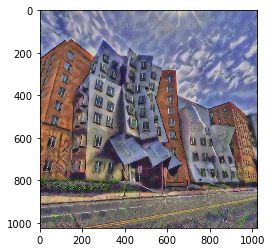

In [51]:
output_image = imageio.imread("data/style_transfer/output/generated_image_5.jpg")
imshow(output_image)